In [9]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import Normalize
import glob
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [10]:
nc_files = sorted(glob.glob("C:/Users\locfa_v05v5qi/Documents/escadas_termohalinas/raw/Dataset/**/*.nc", recursive=True))

In [11]:
# Função: verifica se um perfil específico tem escada
def profile_has_staircase(ds, i):

    layers = [
        ds.mask_ml_sf_layer.isel(Nobs=i).values,
        ds.mask_ml_dc_layer.isel(Nobs=i).values,
        ds.mask_gl_sf_layer.isel(Nobs=i).values,
        ds.mask_gl_dc_layer.isel(Nobs=i).values
    ]

    total_layers = sum(np.nansum(l) for l in layers)

    return total_layers > 0

def subset_region(ds):
    # Ajustar longitudes se estiverem em 0–360
    if ds.lon.max() > 180:
        ds = ds.assign_coords(
            lon=((ds.lon + 180) % 360) - 180
        )

    # Criar máscara apenas para a dimensão n (perfis)
    mask = (
        (ds.lat <= 0) & (ds.lat >= -60) &
        (ds.lon >= -50) & (ds.lon <= -20)
    )

    if "Nobs" in ds.dims:
        ds = ds.isel(Nobs=mask)

    return ds


In [12]:
# Procura o primeiro perfil com staircase
found = False

for fname in nc_files:
    ds = xr.open_dataset(fname)
    ds = subset_region(ds)

    if ds.sizes.get("Nobs", 0) == 0: #se não tiver perfis nesse arquivo pule
        ds.close()
        continue

    for i in range(ds.sizes["Nobs"]):

        if profile_has_staircase(ds, i):

            print("Perfil encontrado!")
            print("Arquivo:", fname)
            print("Índice:", i)
            print("Lon:", float(ds.lon[i]))
            print("Lat:", float(ds.lat[i]))

            # Extrai dados do perfil
            pressure = ds.pressure.values
            temperature = ds.ct[i, :].values
            salinity = ds.sa[i, :].values
            
            # ===============================
            # DEFININDO AS MÁSCARAS CORRETAMENTE
            # ===============================
            
            ml_sf = ds.mask_ml_sf_layer.isel(Nobs=i).values
            gl_sf = ds.mask_gl_sf_layer.isel(Nobs=i).values
            
            ml_dc = ds.mask_ml_dc_layer.isel(Nobs=i).values
            gl_dc = ds.mask_gl_dc_layer.isel(Nobs=i).values
            
            # Substituir NaN por 0
            ml_sf = np.nan_to_num(ml_sf, nan=0.0)
            gl_sf = np.nan_to_num(gl_sf, nan=0.0)
            ml_dc = np.nan_to_num(ml_dc, nan=0.0)
            gl_dc = np.nan_to_num(gl_dc, nan=0.0)
            
            print(ml_sf)
            print(gl_sf)
            print("Número de ml salt fingers:", np.max(ml_sf))
            print("Número de gl salt fingers:", np.max(gl_sf))
            print("Número de ml diffusive convection:", np.max(ml_dc))
            print("Número de gl diffusive convection:", np.max(gl_dc))
            
            ds.close()
            found = True
            break

    if found:
        break


Perfil encontrado!
Arquivo: C:/Users\locfa_v05v5qi/Documents/escadas_termohalinas/raw/Dataset\argo_00001000_00001249.nc
Índice: 27
Lon: -43.154998779296875
Lat: -24.805999755859375
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
Número de ml salt fingers: 2.0
Número de gl salt fingers: 1.0
Número de ml diffusive convection: 0.0
Número de gl diffusive convection: 0.0


In [19]:
# essa célula serve para selecionar um perfil de staircase mais complexo (que nao seja só uma ocorrencia no perfil inteiro)
for i in range(ds.sizes["Nobs"]):

    # ===============================
    # EXTRAINDO AS MÁSCARAS
    # ===============================

    ml_sf = ds.mask_ml_sf_layer.isel(Nobs=i).values
    gl_sf = ds.mask_gl_sf_layer.isel(Nobs=i).values
    ml_dc = ds.mask_ml_dc_layer.isel(Nobs=i).values
    gl_dc = ds.mask_gl_dc_layer.isel(Nobs=i).values

    # Remover NaNs
    ml_sf = np.nan_to_num(ml_sf, nan=0.0)
    gl_sf = np.nan_to_num(gl_sf, nan=0.0)
    ml_dc = np.nan_to_num(ml_dc, nan=0.0)
    gl_dc = np.nan_to_num(gl_dc, nan=0.0)

    # ===============================
    # SOMA TOTAL DAS CAMADAS
    # ===============================

    total_sf = np.nansum(ml_sf) + np.nansum(gl_sf)
    total_dc = np.nansum(ml_dc) + np.nansum(gl_dc)

    # ===============================
    # CRITÉRIO DE ESCADA
    # ===============================

    if (total_sf > 5) or (total_dc > 5):

        print("Perfil encontrado!")
        print("Arquivo:", fname)
        print("Índice:", i)
        print("Lon:", float(ds.lon[i]))
        print("Lat:", float(ds.lat[i]))
        print("Total Salt Finger:", total_sf)
        print("Total Diffusive:", total_dc)

        # Extrai dados do perfil
        pressure = ds.pressure.values
        temperature = ds.ct[i, :].values
        salinity = ds.sa[i, :].values

        ds.close()
        found = True
        break


Perfil encontrado!
Arquivo: C:/Users\locfa_v05v5qi/Documents/escadas_termohalinas/raw/Dataset\argo_00001000_00001249.nc
Índice: 85
Lon: -42.834999084472656
Lat: -24.524999618530273
Total Salt Finger: 13.0
Total Diffusive: 0.0


In [27]:
#Extraindo um perfil dc desenvolvido
for i in range(ds.sizes["Nobs"]):

    # ===============================
    # EXTRAINDO AS MÁSCARAS
    # ===============================

    ml_sf = ds.mask_ml_sf_layer.isel(Nobs=i).values
    gl_sf = ds.mask_gl_sf_layer.isel(Nobs=i).values
    ml_dc = ds.mask_ml_dc_layer.isel(Nobs=i).values
    gl_dc = ds.mask_gl_dc_layer.isel(Nobs=i).values

    # Remover NaNs
    ml_sf = np.nan_to_num(ml_sf, nan=0.0)
    gl_sf = np.nan_to_num(gl_sf, nan=0.0)
    ml_dc = np.nan_to_num(ml_dc, nan=0.0)
    gl_dc = np.nan_to_num(gl_dc, nan=0.0)

    # ===============================
    # SOMA TOTAL DAS CAMADAS
    # ===============================

    total_sf = np.nansum(ml_sf) + np.nansum(gl_sf)
    total_dc = np.nansum(ml_dc) + np.nansum(gl_dc)

    # ===============================
    # CRITÉRIO DE ESCADA
    # ===============================

    if (total_dc > 3):

        print("Perfil encontrado!")
        print("Arquivo:", fname)
        print("Índice:", i)
        print("Lon:", float(ds.lon[i]))
        print("Lat:", float(ds.lat[i]))
        print("Total Salt Finger:", total_sf)
        print("Total Diffusive:", total_dc)

        # Extrai dados do perfil
        pressure = ds.pressure.values
        temperature = ds.ct[i, :].values
        salinity = ds.sa[i, :].values

        ds.close()
        found = True
        break

Perfil encontrado!
Arquivo: C:/Users\locfa_v05v5qi/Documents/escadas_termohalinas/raw/Dataset\argo_00001000_00001249.nc
Índice: 95
Lon: -39.222999572753906
Lat: -19.83099937438965
Total Salt Finger: 0.0
Total Diffusive: 5.0


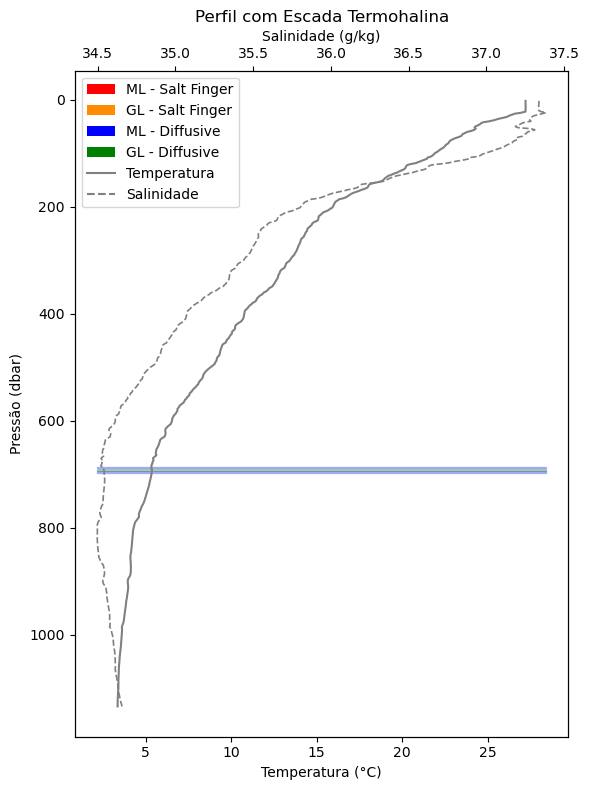

In [28]:
# EXTRAIR MÁSCARAS SEPARADAS

ml_sf = np.nan_to_num(ds.mask_ml_sf.isel(Nobs=i).values, nan=0.0)
gl_sf = np.nan_to_num(ds.mask_gl_sf.isel(Nobs=i).values, nan=0.0)
ml_dc = np.nan_to_num(ds.mask_ml_dc.isel(Nobs=i).values, nan=0.0)
gl_dc = np.nan_to_num(ds.mask_gl_dc.isel(Nobs=i).values, nan=0.0)

mask_ml_sf = ml_sf > 0
mask_gl_sf = gl_sf > 0
mask_ml_dc = ml_dc > 0
mask_gl_dc = gl_dc > 0

# PLOT
fig, ax1 = plt.subplots(figsize=(6, 8))

# Temperatura
ax1.plot(temperature, pressure, linewidth=1.5, color="gray")
ax1.set_xlabel("Temperatura (°C)")
ax1.set_ylabel("Pressão (dbar)")
ax1.invert_yaxis()

# Salinidade
ax2 = ax1.twiny()
ax2.plot(salinity, pressure, linestyle="--", linewidth=1.2, color="gray")
ax2.set_xlabel("Salinidade (g/kg)")

xmin, xmax = ax1.get_xlim()

# SOMBREAMENTO (SÓ SE EXISTIR ALGUM TRUE)

if np.any(mask_ml_sf):
    ax1.fill_betweenx(
        pressure, xmin, xmax,
        where=mask_ml_sf,
        alpha=0.25,
        color="red"
    )

if np.any(mask_gl_sf):
    ax1.fill_betweenx(
        pressure, xmin, xmax,
        where=mask_gl_sf,
        alpha=0.25,
        color="darkorange"
    )

if np.any(mask_ml_dc):
    ax1.fill_betweenx(
        pressure, xmin, xmax,
        where=mask_ml_dc,
        alpha=0.25,
        color="blue"
    )

if np.any(mask_gl_dc):
    ax1.fill_betweenx(
        pressure, xmin, xmax,
        where=mask_gl_dc,
        alpha=0.25,
        color="green"
    )

# LEGENDA MANUAL (SÓ CRIA SE HOUVER DADOS)
legend_elements = [
    Patch(facecolor="red", label="ML - Salt Finger"),
    Patch(facecolor="darkorange", label="GL - Salt Finger"),
    Patch(facecolor="blue", label="ML - Diffusive"),
    Patch(facecolor="green", label="GL - Diffusive"),
    Line2D([0], [0], color="gray", linestyle="-", label="Temperatura"),
    Line2D([0], [0], color="gray", linestyle="--", label="Salinidade"),
]


ax1.legend(handles=legend_elements, loc="best")

plt.title("Perfil com Escada Termohalina")
plt.tight_layout()
plt.show()


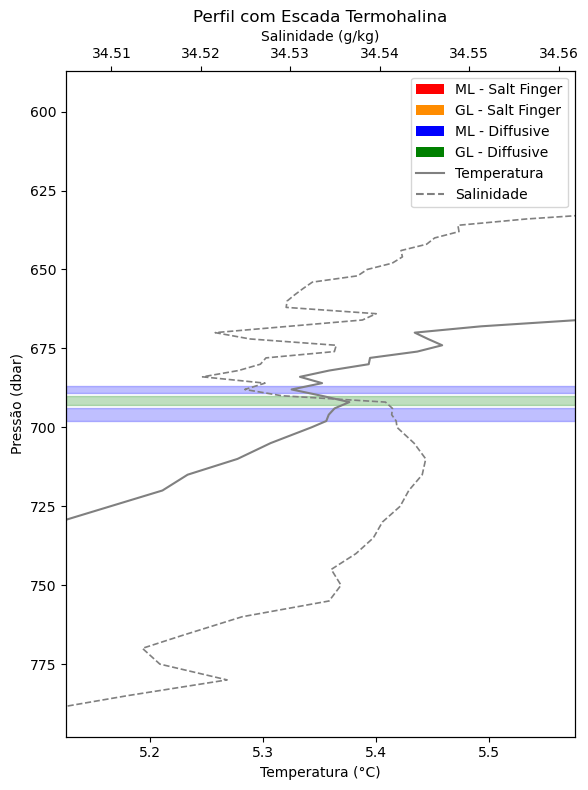

In [29]:
# ======================================================
# EXTRAIR MÁSCARAS
# ======================================================

ml_sf = np.nan_to_num(ds.mask_ml_sf.isel(Nobs=i).values, nan=0.0)
gl_sf = np.nan_to_num(ds.mask_gl_sf.isel(Nobs=i).values, nan=0.0)
ml_dc = np.nan_to_num(ds.mask_ml_dc.isel(Nobs=i).values, nan=0.0)
gl_dc = np.nan_to_num(ds.mask_gl_dc.isel(Nobs=i).values, nan=0.0)

mask_ml_sf = ml_sf > 0
mask_gl_sf = gl_sf > 0
mask_ml_dc = ml_dc > 0
mask_gl_dc = gl_dc > 0

# Máscara total (qualquer regime)
mask_total = mask_ml_sf | mask_gl_sf | mask_ml_dc | mask_gl_dc

# ======================================================
# DEFINIR ZOOM AUTOMÁTICO
# ======================================================

if np.any(mask_total):

    idx = np.where(mask_total)[0]

    # Zoom vertical
    y_min = pressure[idx].min() - 100
    y_max = pressure[idx].max() + 100

    # Zoom horizontal (temperatura e salinidade)
    temp_zoom = temperature[idx]
    salt_zoom = salinity[idx]

    margin_T = 0.2
    margin_S = 0.02

    x1_min = temp_zoom.min() - margin_T
    x1_max = temp_zoom.max() + margin_T

    x2_min = salt_zoom.min() - margin_S
    x2_max = salt_zoom.max() + margin_S

else:
    # Caso não exista staircase
    y_min = pressure.min()
    y_max = pressure.max()

    x1_min = temperature.min()
    x1_max = temperature.max()

    x2_min = salinity.min()
    x2_max = salinity.max()

# ======================================================
# PLOT
# ======================================================

fig, ax1 = plt.subplots(figsize=(6, 8))

# Temperatura
ax1.plot(temperature, pressure, linewidth=1.5, color='gray')
ax1.set_xlabel("Temperatura (°C)")
ax1.set_ylabel("Pressão (dbar)")
ax1.set_ylim(y_min, y_max)
ax1.set_xlim(x1_min, x1_max)
ax1.invert_yaxis()

# Salinidade
ax2 = ax1.twiny()
ax2.plot(salinity, pressure, linestyle="--", linewidth=1.2, color='gray')
ax2.set_xlabel("Salinidade (g/kg)")
ax2.set_xlim(x2_min, x2_max)

xmin, xmax = ax1.get_xlim()

# ======================================================
# SOMBREAMENTO
# ======================================================

def shade(mask, color):
    if np.any(mask):
        ax1.fill_betweenx(
            pressure,
            xmin,
            xmax,
            where=mask,
            alpha=0.25,
            color=color
        )

shade(mask_ml_sf, "red")
shade(mask_gl_sf, "darkorange")
shade(mask_ml_dc, "blue")
shade(mask_gl_dc, "green")

# ======================================================
# LEGENDA
# ======================================================

legend_elements = [
    Patch(facecolor="red", label="ML - Salt Finger"),
    Patch(facecolor="darkorange", label="GL - Salt Finger"),
    Patch(facecolor="blue", label="ML - Diffusive"),
    Patch(facecolor="green", label="GL - Diffusive"),
    Line2D([0], [0], color="gray", linestyle="-", label="Temperatura"),
    Line2D([0], [0], color="gray", linestyle="--", label="Salinidade"),
]

ax1.legend(handles=legend_elements, loc="best")

plt.title("Perfil com Escada Termohalina")
plt.tight_layout()
plt.show()


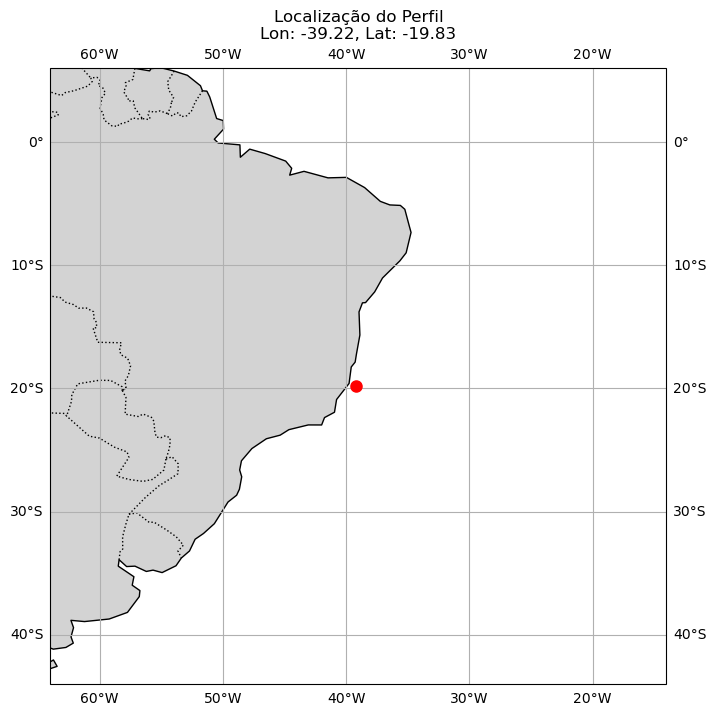

In [30]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Coordenadas do perfil encontrado
lon = ds.lon[i]
lat = ds.lat[i]

# Criar figura e eixo com projeção geográfica
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

lat_min = int(lat) - 25
lat_max = int(lat) + 25
lon_min = int(lon) - 25
lon_max = int(lon) + 25

# Definir limites do mapa (ajuste se quiser mais zoom)
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Adicionar continentes
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# Adicionar contorno dos continentes
ax.add_feature(cfeature.COASTLINE, linewidth=1)

# Adicionar fronteiras (opcional)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Adicionar grade
ax.gridlines(draw_labels=True)

# Plotar o ponto do perfil
ax.plot(lon, lat,
        marker='o',
        color='red',
        markersize=8,
        transform=ccrs.PlateCarree())

# Título
plt.title(f'Localização do Perfil\nLon: {lon:.2f}, Lat: {lat:.2f}')

plt.show()


In [27]:
ds = xr.open_dataset(nc_files[0])
ds.info()
print(ds.dims)
print(ds.sizes)
print(list(ds.data_vars))
print(list(ds.coords))

xarray.Dataset {
dimensions:
	Nobs = 4 ;
	pressure = 2000 ;
	mixed_layers = 100 ;
	gradient_layers = 99 ;

variables:
	int32 n(Nobs) ;
		n:long_name = Profile ;
		n:standard_name = no ;
	float64 prof(Nobs) ;
		prof:long_name = Profile number of float ;
		prof:standard_name = prof ;
	float64 FloatID(Nobs) ;
		FloatID:long_name = Float ID ;
		FloatID:standard_name = FloatID ;
	float32 juld(Nobs) ;
		juld:long_name = Julian date of profile ;
		juld:standard_name = juld ;
		juld:units = days after 1950-01-01 ;
	float32 lon(Nobs) ;
		lon:long_name = Longitude of float ;
		lon:standard_name = lon ;
		lon:units = degrees ;
	float32 lat(Nobs) ;
		lat:long_name = Latitude of float ;
		lat:standard_name = lat ;
		lat:units = degrees ;
	float32 ct(Nobs, pressure) ;
		ct:long_name = Conservative Temperature ;
		ct:standard_name = ct ;
		ct:units = degrees Celsius ;
	float32 sa(Nobs, pressure) ;
		sa:long_name = Absolute Salinity ;
		sa:standard_name = sa ;
		sa:units = g/kg ;
	float32 ml_T(Nobs, m